# Capstone Two #

## Predicting Test Performance for Specialised High School Admissions ##

Performance on the Specialized High School Admissions Test (SHSAT) determines eligibility to one of the eight specialized high schools in New York City. It is administered by the New York City Department of Education (DOE) to about a third of the city’s 8th graders, with 5,000 receiving admissions offers. Of major concern is the racial & ethnic breakdown of admitted students, showing significant underrepresentation from black and latinx students. 

The goal of this analysis is to elicit which factors predict performance on the SHSAT. These factors will serve as beacons to direct or draw services, whether education-based or otherwise, towards improving the percentage of black and latinx students admitted to the specialized high schools. 

This approach aims to quantify which variables lead to admissions offers beyond prior proxies: English Language Learners, Students with Disabilities, Students on Free/Reduced Lunch, and Students with Temporary Housing.

In [49]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import urllib.request
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Data Collection & Loading Data Sets ###

Two main data sets will be used:

*2016 School Explorer*  
This dataset consists of 1272 schools in New York city, and 161 variables, provided via kaggle. Primarily, it’s school descriptors, e.g. grades, race & ethnicity student percentages, high/low performing percentages of students. Data is available as a single csv file.

*2017-2018 SHSAT Admissions Test Offers By Sending School*  
This dataset consists of the 2017 SHSAT results, published by NYC in 2018. All test takers are north of 28,000, grade 8 students, Test takers and offers received are grouped by school. Data is available as a single csv file from the NYC Open Data portal.

In [3]:
#downloading the 2016 School Explorer data set to raw folder
url = 'https://storage.googleapis.com/kagglesdsdata/datasets%2F33225%2F44131%2F2016%20School%20Explorer.csv?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1595273466&Signature=fk6%2BI64ZSKXeenOP24Hsst9gNp2z3gFDGnz1rSXzcrnS874EFfR1VjUPVu0mCoN0bwXxJ7udjKpGlD51QLqiolRTpt9t%2F6ko672nNzd2KU0zJd4xRN8yW4Ouk1XxbCCTN2u6In241T1%2BY1RMpSp5rQgko83zQtwPClQPsl%2BWynlztsHV1aWF2K1J6MUy1SBaXyHvTSXBiMp1G2FvCoVjRVyjkXwV94Xgayi8Zgs3ISjyVUZn3yYzuyarl8NUwSnryWnfCE1debgt5z9AP5aTv7IbUA297hpYAhHZR0NjtKMwoadxypbWbBZ6cUTgI8KT4L4q8LdCgJ6SDJolkJERaQ%3D%3D'
file_explorer = '../data/raw/2016_School_Explorer.csv'
urllib.request.urlretrieve(url, file_explorer)

#downloading the 2017-2018 SHSAT data set to raw folder
url = 'https://data.cityofnewyork.us/resource/vsgi-eeb5.csv'
file_offers = '../data/raw/2017-2018_SHSAT_Admissions_Test_Offers_By_Sending_School.csv'
urllib.request.urlretrieve(url, file_offers)

In [4]:
#loading data sets
df_explorer = pd.read_csv(file_explorer)
df_offers = pd.read_csv(file_offers)

In [5]:
df_explorer.head(3)

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),...,Grade 8 Math - All Students Tested,Grade 8 Math 4s - All Students,Grade 8 Math 4s - American Indian or Alaska Native,Grade 8 Math 4s - Black or African American,Grade 8 Math 4s - Hispanic or Latino,Grade 8 Math 4s - Asian or Pacific Islander,Grade 8 Math 4s - White,Grade 8 Math 4s - Multiracial,Grade 8 Math 4s - Limited English Proficient,Grade 8 Math 4s - Economically Disadvantaged
0,NaN,NaN,NaN,P.S. 015 ROBERTO CLEMENTE,310100010015,01M015,1,40.721834,-73.978766,"333 E 4TH ST NEW YORK, NY 10009",...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,NaN,P.S. 019 ASHER LEVY,310100010019,01M019,1,40.729892,-73.984231,"185 1ST AVE NEW YORK, NY 10003",...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,P.S. 020 ANNA SILVER,310100010020,01M020,1,40.721274,-73.986315,"166 ESSEX ST NEW YORK, NY 10002",...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_offers.head()

,feeder_school_dbn,feeder_school_name,count_of_students_in_hs_admissions,count_of_testers,count_of_offers
0,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,58.0,6,0-5
1,01M140,P.S. 140 NATHAN STRAUS,67.0,6,0-5
2,01M184,P.S. 184M SHUANG WEN,88.0,67,23
3,01M188,P.S. 188 THE ISLAND SCHOOL,59.0,0-5,0-5
4,01M301,"TECHNOLOGY, ARTS, AND SCIENCES STUDIO",51.0,11,0-5


### Data Definitions ###

Generally exploring both datasets to understand what's in them.

In [7]:
df_explorer.columns

Index(['Adjusted Grade', 'New?', 'Other Location Code in LCGMS', 'School Name',
       'SED Code', 'Location Code', 'District', 'Latitude', 'Longitude',
       'Address (Full)',
       ...
       'Grade 8 Math - All Students Tested', 'Grade 8 Math 4s - All Students',
       'Grade 8 Math 4s - American Indian or Alaska Native',
       'Grade 8 Math 4s - Black or African American',
       'Grade 8 Math 4s - Hispanic or Latino',
       'Grade 8 Math 4s - Asian or Pacific Islander',
       'Grade 8 Math 4s - White', 'Grade 8 Math 4s - Multiracial',
       'Grade 8 Math 4s - Limited English Proficient',
       'Grade 8 Math 4s - Economically Disadvantaged'],
      dtype='object', length=161)

In [8]:
df_explorer.shape

(1272, 161)

In [9]:
df_explorer.describe().T

,count,mean,std,min,25%,50%,75%,max
SED Code,1272.0,3.286698e+11,1.222022e+10,3.075000e+11,3.208752e+11,3.315004e+11,3.424000e+11,3.531009e+11
District,1272.0,1.613522e+01,9.245270e+00,1.000000e+00,9.000000e+00,1.500000e+01,2.400000e+01,3.200000e+01
Latitude,1272.0,4.073454e+01,8.660234e-02,4.050780e+01,4.066950e+01,4.072299e+01,4.081563e+01,4.090346e+01
Longitude,1272.0,-7.391835e+01,8.057649e-02,-7.424402e+01,-7.395706e+01,-7.392057e+01,-7.387926e+01,-7.370892e+01
Zip,1272.0,1.081572e+04,5.295889e+02,1.000100e+04,1.045200e+04,1.120300e+04,1.123200e+04,1.169400e+04
...,...,...,...,...,...,...,...,...
Grade 8 Math 4s - Asian or Pacific Islander,1272.0,1.984277e+00,1.284133e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.460000e+02
Grade 8 Math 4s - White,1272.0,9.709119e-01,6.880223e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.260000e+02
Grade 8 Math 4s - Multiracial,1272.0,2.358491e-03,8.411582e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
Grade 8 Math 4s - Limited English Proficient,1272.0,1.595912e-01,1.321195e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+01


We can tell that there are 161 variables in the 2016 School Explorer data set with 1,272 rows of data consisting of physical descriptors and descriptive statistics information for all of the schools.

In [10]:
df_offers.columns

Index(['feeder_school_dbn', 'feeder_school_name',
       'count_of_students_in_hs_admissions', 'count_of_testers',
       'count_of_offers'],
      dtype='object')

In [11]:
df_offers.shape

(594, 5)

In [12]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   feeder_school_dbn                   594 non-null    object 
 1   feeder_school_name                  594 non-null    object 
 2   count_of_students_in_hs_admissions  593 non-null    float64
 3   count_of_testers                    594 non-null    object 
 4   count_of_offers                     594 non-null    object 
dtypes: float64(1), object(4)
memory usage: 23.3+ KB


The 2017-2018 SHSAT Admissions Test Offers By Sending School has 5 variables with 594 rows of data consisting of names and descriptive statistics for all of the schools. This makes sense because not all schools send students to the SHSAT.

**Initial Data Cleaning**

Let's determine the null values and then appropriately address what to do with them.

In [13]:
nas=pd.DataFrame(df_explorer.isnull().sum().sort_values(ascending=False)/len(df_explorer),columns = ['Percent'])
pos = nas['Percent'] > 0
nas[pos]

,Percent
Other Location Code in LCGMS,0.999214
Adjusted Grade,0.998428
New?,0.978774
School Income Estimate,0.311321
Student Achievement Rating,0.067610
Supportive Environment Rating,0.062893
Collaborative Teachers Rating,0.059748
Rigorous Instruction Rating,0.059748
Trust Rating,0.057390
Strong Family-Community Ties Rating,0.057390


We can see that the *explorer* data set has three columns almost entirely of null values. These can be filled with an appropriate value for the data type of those columns.

In [14]:
nas=pd.DataFrame(df_offers.isnull().sum().sort_values(ascending=False)/len(df_offers),columns = ['Percent'])
pos = nas['Percent'] > 0
nas[pos]

,Percent
count_of_students_in_hs_admissions,0.001684


The *offers* data set is pretty clean and doesn't need to have null values addressed.

In [15]:
#determine existing values of high-NaN columns identified above, for 2016 School Explorer dataframe
print(df_explorer['Other Location Code in LCGMS'].describe())
print(df_explorer['Adjusted Grade'].describe())
df_explorer['New?'].describe()

count          1
unique         1
top       75k372
freq           1
Name: Other Location Code in LCGMS, dtype: object
count     2
unique    1
top       x
freq      2
Name: Adjusted Grade, dtype: object


count     27
unique     1
top        x
freq      27
Name: New?, dtype: object

In [6]:
#replacing the null values with 'n' for no/ne
df_explorer['Other Location Code in LCGMS'].fillna('n', inplace=True)
df_explorer['Adjusted Grade'].fillna('n', inplace = True)
df_explorer['New?'].fillna('n', inplace=True)

The school income estimate column, which has more than 30% of its values equal to null, seems to not be a numeric data type.

In [6]:
df_explorer['School Income Estimate'].describe()

count             876
unique            876
top       $36,588.31 
freq                1
Name: School Income Estimate, dtype: object

In [7]:
df_explorer['School Income Estimate Numeric'] = df_explorer['School Income Estimate'].str.replace('$','').str.replace(',','').astype(float)

In [8]:
df_explorer['School Income Estimate Numeric'].fillna(0, inplace=True)
df_explorer['School Income Estimate Numeric'].isnull().sum()

0

Nice!

### Exploratory Data Analysis ###

Building data profile tables and plots, exploring data relationships, and identifying & creating features.

In [9]:
df_explorer.iloc[:,121:141].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 20 columns):
 #   Column                                              Non-Null Count  Dtype
---  ------                                              --------------  -----
 0   Grade 7 ELA - All Students Tested                   1272 non-null   int64
 1   Grade 7 ELA 4s - All Students                       1272 non-null   int64
 2   Grade 7 ELA 4s - American Indian or Alaska Native   1272 non-null   int64
 3   Grade 7 ELA 4s - Black or African American          1272 non-null   int64
 4   Grade 7 ELA 4s - Hispanic or Latino                 1272 non-null   int64
 5   Grade 7 ELA 4s - Asian or Pacific Islander          1272 non-null   int64
 6   Grade 7 ELA 4s - White                              1272 non-null   int64
 7   Grade 7 ELA 4s - Multiracial                        1272 non-null   int64
 8   Grade 7 ELA 4s - Limited English Proficient         1272 non-null   int64
 9   Grade 7 ELA 4s - Ec

Given the test-takers in the 2017-2018's df_offers are a year away from taking the test in 2016's df_explorer, I'll focus on the 7th graders.

df_explorer has 20 variables with information 7th graders. This data is broken up into two kinds of information, ELA (English Language Arts) & Math. Scoring on these tests top out at 4, with 1 representing the worst score.

Therefore, the best students are in the '4s' columns shown above. 

Summary of columns:

- All students tested
- All students with 4 scores
- American Indian or Alaska Native with 4 scores
- Black or African American students with 4 scores
- Hispanic or Latino students with 4 scores
- Asian or Pacific Islander students with 4 scores
- White students with 4 scores
- Multiracial students with 4 scores
- Limited English Proficient students with 4 scores
- Economically Disadvantaged with 4 scores


In [75]:
#subsetting df_explorer data for just the 7th graders
df_ela = df_explorer.iloc[:,121:131]
df_math = df_explorer.iloc[:,131:141]

In [76]:
ethnicity = ['Black','Latino','Asian','White']
df_ela_totals = pd.DataFrame({'ethnicity':ethnicity,'totals':[i for i in df_ela.iloc[:,3:7].sum()]})
df_math_totals = pd.DataFrame({'ethnicity':ethnicity,'totals':[i for i in df_math.iloc[:,3:7].sum()]})
print(df_math.sum()[0], df_ela.sum()[1], df_math.sum()[1])

69053 8320 10888


In 2016, the total number of 7th graders in NYC Middle Schools was **69,053**. Of those, **8,320** had ELA scores of 4, and **10,888** had Math scores of 4.

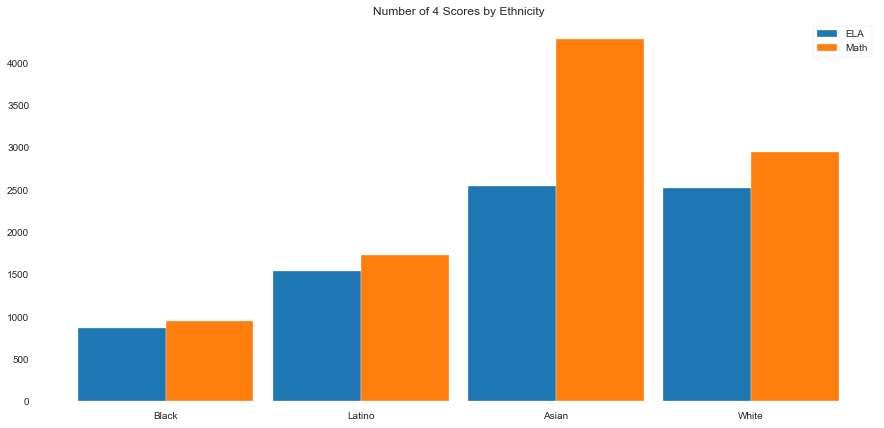

In [77]:
_ = plt.figure(figsize = (15,7))
_ = plt.title('Number of 4 Scores by Ethnicity')
w = 0.45
ela_bar = plt.bar(np.arange(len(df_ela_totals)), df_ela_totals.totals, width = w, align = 'center', label = 'ELA')
math_bar = plt.bar(np.arange(len(df_ela_totals))+w, df_math_totals.totals, width = w, align = 'center', 
                   label = 'Math')
_ = plt.xticks(np.arange(4)+0.225, ethnicity)
_ = plt.legend(handles=[ela_bar,math_bar], loc = 'upper right')

Using the assumption that those ethnicities that have the majority of the 4 scores will, in turn, perform well on the aptitude test for the specialized high school, we can see why Black & Latino may receive less admittance offers based on these limited criteria.

In [9]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   feeder_school_dbn                   594 non-null    object 
 1   feeder_school_name                  594 non-null    object 
 2   count_of_students_in_hs_admissions  593 non-null    float64
 3   count_of_testers                    594 non-null    object 
 4   count_of_offers                     594 non-null    object 
dtypes: float64(1), object(4)
memory usage: 23.3+ KB


df_offers contains all middle school 8th graders who took the SHSAT. 

In both the count_of_testers and count_of_offers columns, a school with less that 5 students, the value reads as '0-5' 8th graders.

In [19]:
testers = pd.to_numeric(df_offers.count_of_testers[df_offers.count_of_testers != '0-5'])
offers = pd.to_numeric(df_offers.count_of_offers[df_offers.count_of_offers != '0-5'])

In [28]:
print(len(testers),testers.sum(), len(offers), offers.sum())
print(len(df_offers.count_of_testers[df_offers.count_of_testers == '0-5']), 
      len(df_offers.count_of_offers[df_offers.count_of_offers == '0-5']))

537 25349 121 4018
57 473


**537** NYC Middle Schools sent at least 6 students to SHSAT for a total of **25,349** 8th graders taking the test. **57** schools send 0-5 8th graders to take the test. **121** NYC Middle Schools saw at least 6 of their students receive offers, for a total of **4,018** 8th graders having received an offer. **473** schools saw 0-5 of their 8th graders receive an offer.

**Merging Datasets**

Using the DBN & Location Code I'll merge df_explorer data for 7th graders to the df_offers information for SHSAT testers.

In [10]:
df_exp_subset = df_explorer.loc[:,['Location Code', 'District', 'Latitude', 'Longitude', 'Percent ELL', 
                                       'Percent Asian','Percent Black', 'Percent Hispanic', 
                                   'Percent Black / Hispanic','Percent White', 'Average ELA Proficiency', 
                                   'Average Math Proficiency', 'Grade 7 ELA - All Students Tested', 
                                   'Grade 7 ELA 4s - All Students', 'Grade 7 Math - All Students Tested', 
                                   'Grade 7 Math 4s - All Students']]

In [43]:
df_main = df_offers.merge(df_exp_subset, left_on = 'feeder_school_dbn', right_on = 'Location Code')

In [44]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 590
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   feeder_school_dbn                   591 non-null    object 
 1   feeder_school_name                  591 non-null    object 
 2   count_of_students_in_hs_admissions  591 non-null    float64
 3   count_of_testers                    591 non-null    object 
 4   count_of_offers                     591 non-null    object 
 5   Location Code                       591 non-null    object 
 6   District                            591 non-null    int64  
 7   Latitude                            591 non-null    float64
 8   Longitude                           591 non-null    float64
 9   Percent ELL                         591 non-null    object 
 10  Percent Asian                       591 non-null    object 
 11  Percent Black                       591 non-n

Looks like **2** of the schools in df_offers aren't in the df_explorer data.

I'll also add a few more columns:

- “Percentage of SHSAT takers receiving an offer” (Numbers of SHSAT takers/Number of Offers by school)
- “The total number of Black/Hispanic students in Grade 8” (Number of 8th graders * Percent Black / Hispanic)
- “Percentage of students who did the SHSAT” (Number of SHSAT takers/Number of 8th graders)
- “Average Mark” (the average of Average ELA Proficiency and Average Math Proficiency)
- “Percent of students with Level 4 ELA in Grade 7 (Grade 7 ELA 4s - All Students/Grade 7 ELA - All Students Tested)
- “Percent of students with Level 4 Math in Grade 7 (Grade 7 Math 4s - All Students/Grade 7 Math - All Students Tested)
- “Percent of students with Level 4 in Grade 7” (average of 4 percentages ELA and Math in Grade 7)
- “Average number of Level 4 students” (Grade 7 ELA 4s - All Students + Grade 7 Math 4s - All Students)/2

In [45]:
#filling NaN
df_main['Average ELA Proficiency'].fillna(0, inplace = True)
df_main['Average Math Proficiency'].fillna(0, inplace = True)

#modifying data types
df_main['PctELL'] = df_main['Percent ELL'].str.extract('(\d+)').astype(int)
df_main['PctAsian'] = df_main['Percent Asian'].str.extract('(\d+)').astype(int)
df_main['PctBlack'] = df_main['Percent Black'].str.extract('(\d+)').astype(int)
df_main['PctHispanic'] = df_main['Percent Hispanic'].str.extract('(\d+)').astype(int)
df_main['PctWhite'] = df_main['Percent White'].str.extract('(\d+)').astype(int)
df_main['PctBlackOrHispanic'] = df_main['Percent Black / Hispanic'].str.extract('(\d+)').astype(int)

df_main['NumTestTakers'] = pd.to_numeric(df_main.count_of_testers, errors = 'coerce', downcast = 'signed')
df_main['NumSpecializedOffers'] = pd.to_numeric(df_main.count_of_offers, errors = 'coerce', downcast = 'signed')
df_main.NumTestTakers.fillna(0, inplace = True)
df_main.NumSpecializedOffers.fillna(0, inplace = True)

#Adding calculated columns
df_main['PctOffersByStudent'] = round((df_main.NumSpecializedOffers / df_main.NumTestTakers) * 100, 0)
df_main.PctOffersByStudent.fillna(0, inplace = True)

df_main['TotalGrade8BlHisp'] = round((df_main.count_of_students_in_hs_admissions * df_main.PctBlackOrHispanic) 
                                     / 100)
df_main['PerDidSHSAT'] = round((df_main.NumTestTakers / df_main.count_of_students_in_hs_admissions) * 100)
df_main['AvgMark'] = round((df_main['Average ELA Proficiency'] + df_main['Average Math Proficiency'])/2, 2)
df_main['PctScore4ELA'] = round((df_main['Grade 7 ELA 4s - All Students'] / 
                                 df_main['Grade 7 ELA - All Students Tested']) * 100)
df_main['PctScore4Math'] = round((df_main['Grade 7 Math 4s - All Students'] / 
                                   df_main['Grade 7 Math - All Students Tested']) * 100)
df_main['AvgScore4'] = round((df_main['Grade 7 ELA 4s - All Students'] + 
                             df_main['Grade 7 Math 4s - All Students']) / 2, 1)
df_main['PctScore4'] = round((df_main.PctScore4ELA + df_main.PctScore4Math) / 2)

df_main.PctScore4ELA.fillna(0, inplace = True)
df_main.PctScore4Math.fillna(0, inplace = True)
df_main.PctScore4.fillna(0, inplace = True)

In [190]:
#Generating a Profile Report as a general overview of the data.
profile = ProfileReport(df_main, title = 'Capstone Two Profile Report')
profile.to_file("../reports/CapstoneTwo.html")
profile.to_notebook_iframe()

#Generating an explorative report
profile_exp = ProfileReport(df_main, title='Capstone Two Explorative Profiling Report', explorative=True)
profile_exp.to_file("../reports/CapstoneTwo_Explorative.html")

**Schools with highest number of test takers**

What we're seeing in this next plot is that those schools that send the most 8th graders to the SHSAT, have less of their school, percentage-wise, represented by Black or Latino students.

Interestingly, there is a high percentage of Black/Hispanic students (The William W. Niles school (82%), and The Eugenio Maria De Hostos school(78%), near the middle of the pack and the lowest, respectively.

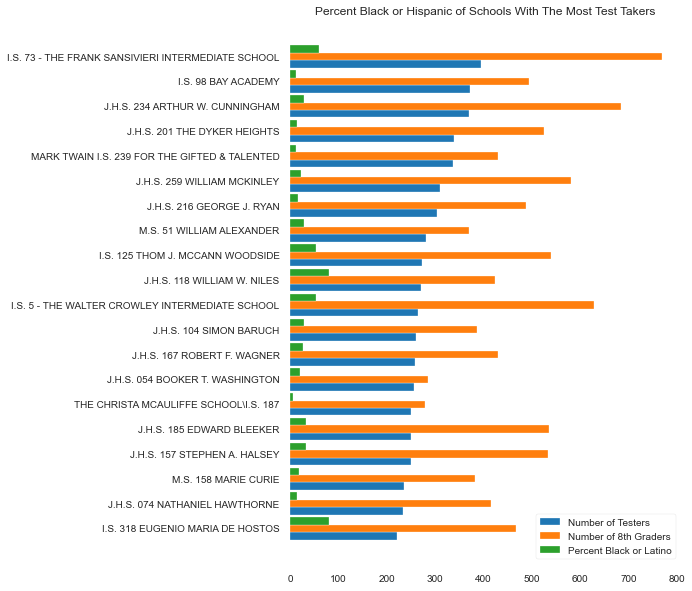

In [139]:
most_testtakers = df_main.nlargest(20, 'NumTestTakers', keep = 'all')
_ = plt.figure(figsize = (7,10))
_ = plt.title('Percent Black or Hispanic of Schools With The Most Test Takers')
h = 0.3
testers = plt.barh(np.arange(len(most_testtakers))+h, most_testtakers.NumTestTakers, height = h, 
                   label = 'Number of Testers')
eight_graders = plt.barh(np.arange(len(most_testtakers)), most_testtakers.count_of_students_in_hs_admissions, 
                         height = h, label = 'Number of 8th Graders')
pct_blk_hisp = plt.barh(np.arange(len(most_testtakers))-h, most_testtakers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
_ = plt.gca().invert_yaxis()
plt.yticks(np.arange(len(most_testtakers)), most_testtakers.feeder_school_name)
_ = plt.legend(handles=[testers,eight_graders,pct_blk_hisp], loc = 'best')

**Schools with the least number of test takers**

Nearly all of the schools with the least number of test takers in 2017 (55) had low average marks (average of AvgELA and AvgMath). 

Also, most schools had a high percentage of Black or Hispanic students.

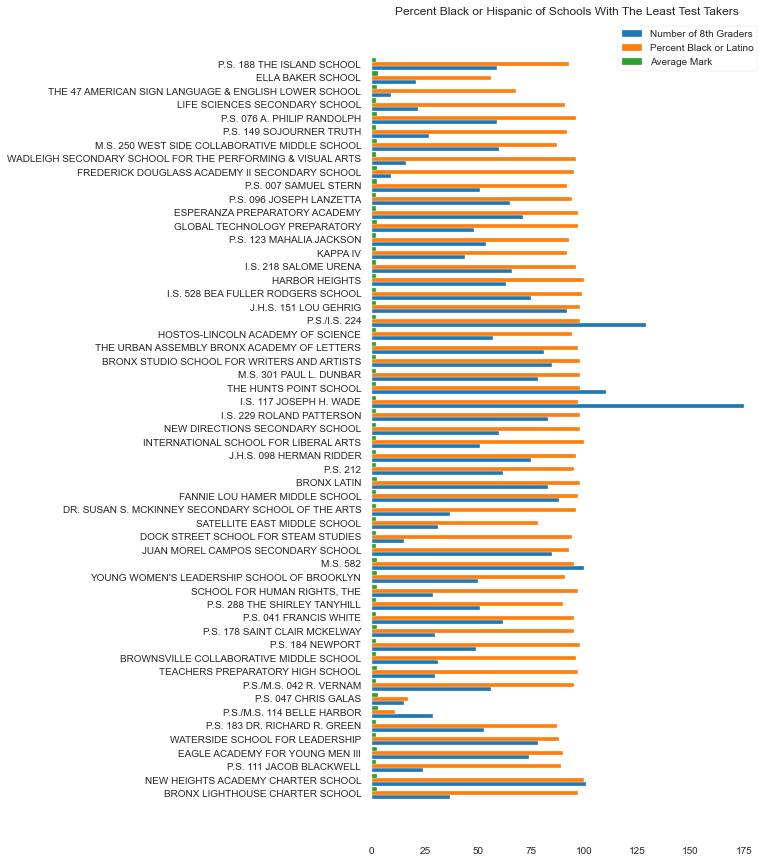

In [125]:
least_testtakers = df_main[df_main.NumTestTakers == 0]
_ = plt.figure(figsize = (7,15))
_ = plt.title('Percent Black or Hispanic of Schools With The Least Test Takers')
h = 0.3
eighth_graders = plt.barh(np.arange(len(least_testtakers))+h, least_testtakers.count_of_students_in_hs_admissions, 
                         height = h, label = 'Number of 8th Graders')
pct_blk_hisp = plt.barh(np.arange(len(least_testtakers)), least_testtakers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
average_mark = plt.barh(np.arange(len(least_testtakers))-h, least_testtakers.AvgMark, height = h, 
                        label = 'Average Mark')
plt.yticks(np.arange(len(least_testtakers)), least_testtakers.feeder_school_name)
_ = plt.legend(handles=[eighth_graders,pct_blk_hisp,average_mark], loc = 'upper right')

**Numbers of Offers by school**

The top 25 schools with the most offers received had lower percentages of Black or Hispanic students (highest percentage is at Frank Sansivieri school with 59% Black or Hispanic students).

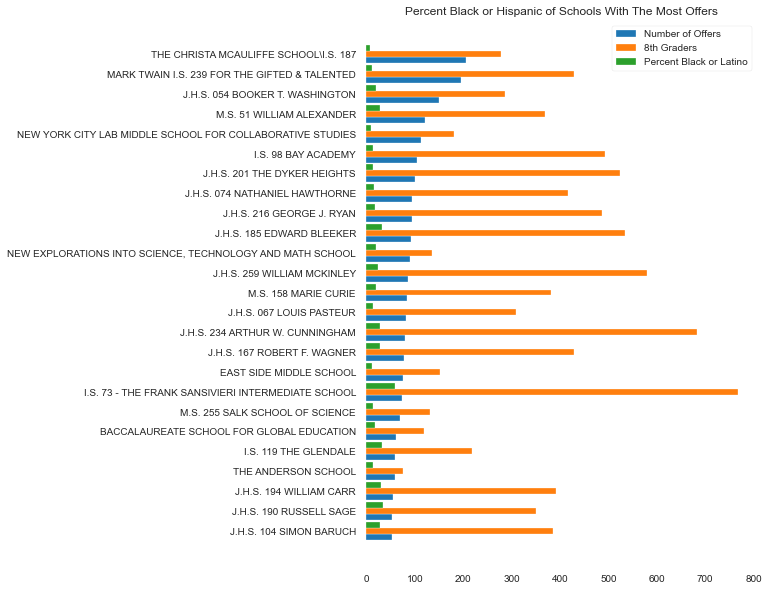

In [138]:
most_offers = df_main.sort_values(by = 'NumSpecializedOffers', ascending=False).head(25)
_ = plt.figure(figsize = (7,10))
_ = plt.title('Percent Black or Hispanic of Schools With The Most Offers')
h = 0.3
highest_offers = plt.barh(np.arange(len(most_offers))+h, most_offers.NumSpecializedOffers, height = h, 
                          label = 'Number of Offers')
eighth_graders = plt.barh(np.arange(len(most_offers)), most_offers.count_of_students_in_hs_admissions, height = h, 
                        label = '8th Graders')
pct_blk_hisp = plt.barh(np.arange(len(most_offers))-h, most_offers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
_ = plt.gca().invert_yaxis()
plt.yticks(np.arange(len(most_offers)), most_offers.feeder_school_name)
_ = plt.legend(handles=[highest_offers, eighth_graders,pct_blk_hisp], loc = 'upper right')

**Highest Percentage of Offers for the Number of Test Takers**

Below are the top 20 schools that had the highest percentage of offers for the number of test takers, representing how successful that school was as to the number of students that were admitted to the specialized high school.

The Christa McAuliffe School had the msot success with 82% of 251 students taking the test getting an offer.

The schools scoring best at the percentage of students actually getting an offer are very low in Black or Latinx student percentages (the exception is the small Columbia Secondary School with 64% Black/Latinos).

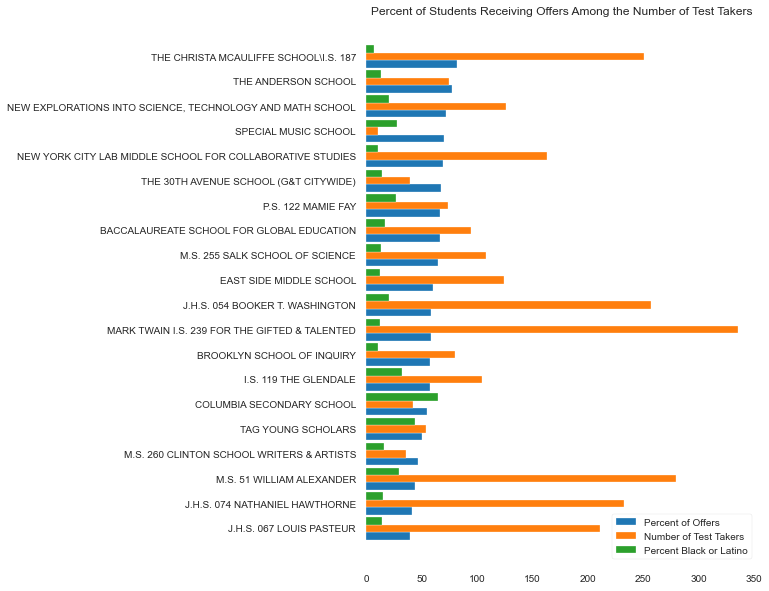

In [122]:
pct_offers = df_main.sort_values(by = 'PctOffersByStudent', ascending=False).head(20)
_ = plt.figure(figsize = (7,10))
_ = plt.title('Percent of Students Receiving Offers Among the Number of Test Takers')
h = 0.3
pct_of_offers = plt.barh(np.arange(len(pct_offers))+h, pct_offers.PctOffersByStudent, height = h, 
                         label = 'Percent of Offers')
num_test_takers = plt.barh(np.arange(len(pct_offers)), pct_offers.NumTestTakers, height = h, 
                           label = 'Number of Test Takers')
pct_blk_hisp = plt.barh(np.arange(len(pct_offers))-h, pct_offers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
_ = plt.gca().invert_yaxis()
plt.yticks(np.arange(len(pct_offers)), pct_offers.feeder_school_name)
_ = plt.legend(handles=[pct_of_offers,num_test_takers,pct_blk_hisp], loc = 'best')

Below are the top 20 schools that had the highest percentage of offers for the number of test takers, along with the percentage of the school that was made up of 4 score students and their average proficiency (Average Mark).

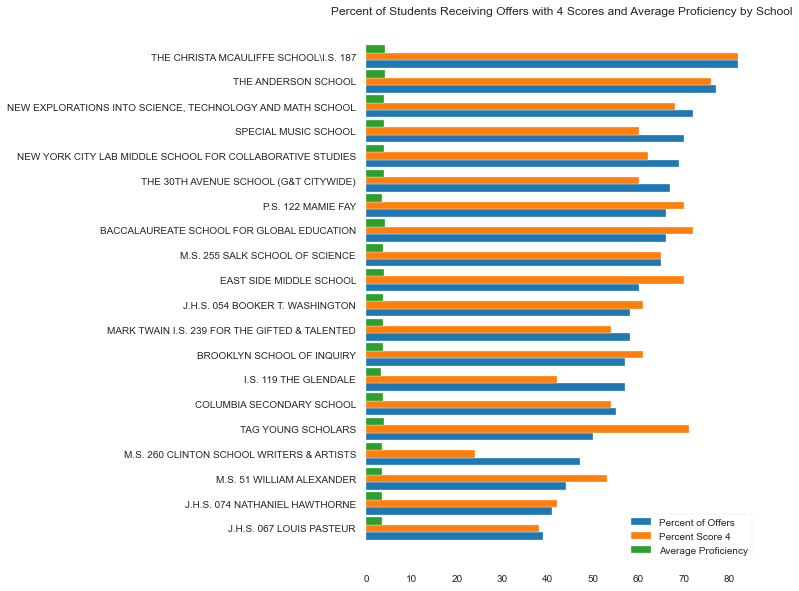

In [171]:
_ = plt.figure(figsize = (7,10))
_ = plt.title('Percent of Students Receiving Offers with 4 Scores and Average Proficiency by School')
h = 0.3
pct_of_offers = plt.barh(np.arange(len(pct_offers))+h, pct_offers.PctOffersByStudent, height = h, 
                         label = 'Percent of Offers')
pct_score_4 = plt.barh(np.arange(len(pct_offers)), pct_offers.PctScore4, height = h, 
                           label = 'Percent Score 4')
avg_mark = plt.barh(np.arange(len(pct_offers))-h, pct_offers.AvgMark, height = h, 
                        label = 'Average Proficiency')
_ = plt.gca().invert_yaxis()
plt.yticks(np.arange(len(pct_offers)), pct_offers.feeder_school_name)
_ = plt.legend(handles=[pct_of_offers,pct_score_4,avg_mark], loc = 'best')

**Least Percentage of Offers for the Number of Test Takers**

Of those schools which had at least 6 offrs, the 20 schools with least success are shown below. 

Two of the largest schools that are predominatly Black/Hispanic and sent many students to the test are J.H.S 118 William W. Niles school @ 424 8th graders (82% Black/Hispanic) and I.S. 318 Eugenio Maria De Hostos @ 467 8th graders (78% Black/Hispanic).

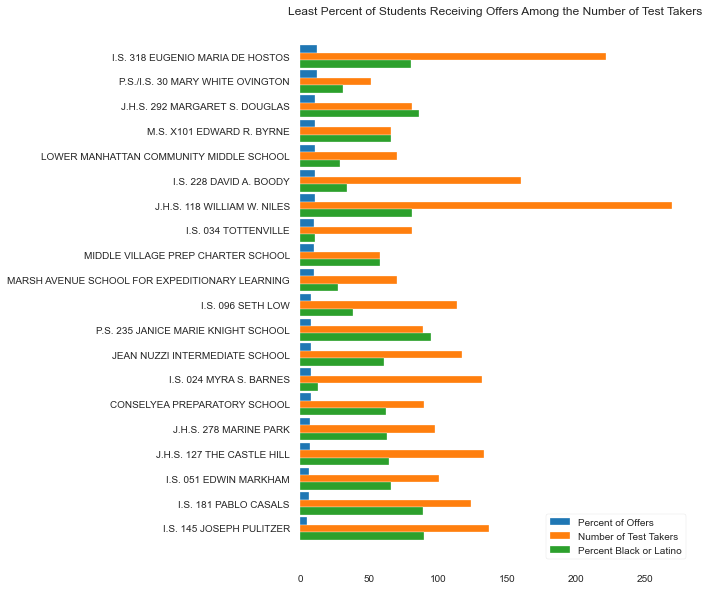

In [170]:
least_pct_offers = df_main[df_main.NumSpecializedOffers > 0].sort_values(by = 'PctOffersByStudent').head(20)
_ = plt.figure(figsize = (7,10))
_ = plt.title('Least Percent of Students Receiving Offers Among the Number of Test Takers')
h = 0.3
least_pct_of_offers = plt.barh(np.arange(len(least_pct_offers))+h, least_pct_offers.PctOffersByStudent, height = h, 
                         label = 'Percent of Offers')
lnum_test_takers = plt.barh(np.arange(len(least_pct_offers)), least_pct_offers.NumTestTakers, height = h, 
                           label = 'Number of Test Takers')
lpct_blk_hisp = plt.barh(np.arange(len(least_pct_offers))-h, least_pct_offers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
_ = plt.yticks(np.arange(len(least_pct_offers)), least_pct_offers.feeder_school_name)
_ = plt.legend(handles=[least_pct_of_offers,lnum_test_takers,lpct_blk_hisp], loc = 'best')

Almost all schools had a low percentage of Level4 students, and Average Marks. 

An interesting exception is the **Janice Marie Knight school**, which has a decent percentage of Score 4 students.

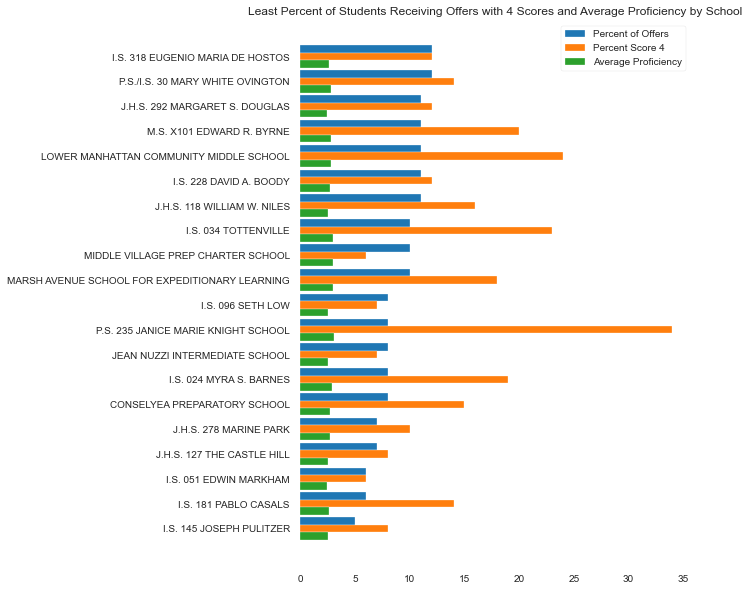

In [173]:
_ = plt.figure(figsize = (7,10))
_ = plt.title('Least Percent of Students Receiving Offers with 4 Scores and Average Proficiency by School')
h = 0.3
least_pct_of_offers = plt.barh(np.arange(len(least_pct_offers))+h, least_pct_offers.PctOffersByStudent, height = h, 
                         label = 'Percent of Offers')
lpct_score_4 = plt.barh(np.arange(len(least_pct_offers)), least_pct_offers.PctScore4, height = h, 
                           label = 'Percent Score 4')
lavg_mark = plt.barh(np.arange(len(least_pct_offers))-h, least_pct_offers.AvgMark, height = h, 
                        label = 'Average Proficiency')
#_ = plt.gca().invert_yaxis()
_ = plt.yticks(np.arange(len(least_pct_offers)), least_pct_offers.feeder_school_name)
_ = plt.legend(handles=[least_pct_of_offers,lpct_score_4,lavg_mark], loc = 'best')

**Boxplots**

This kind of plot doesn't really help explain relationships in this data but I thought I'd try it anyway.

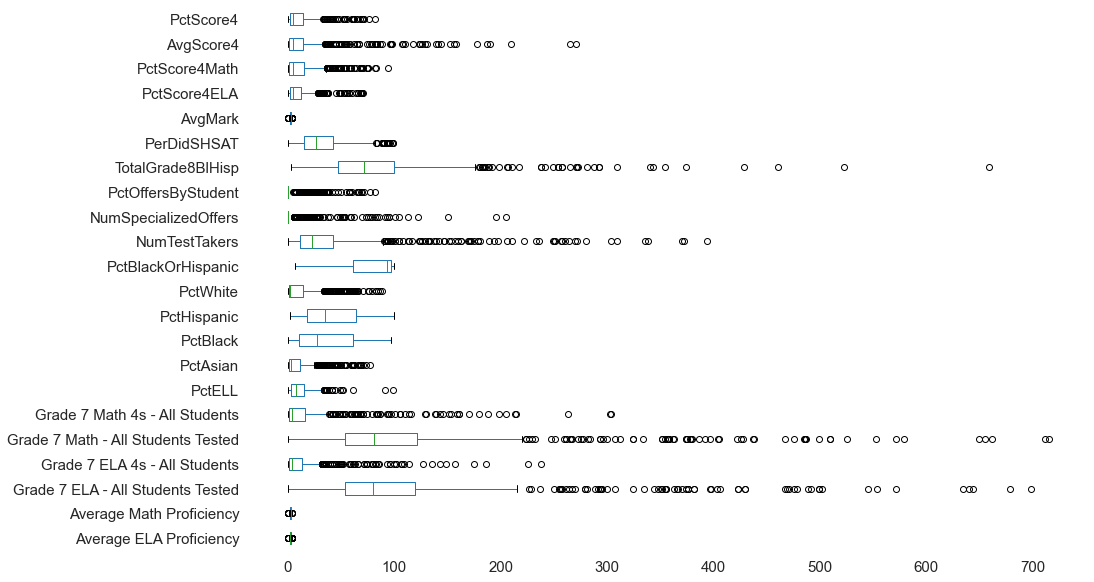

In [234]:
_ = plt.figure(figsize = (15,10))
boxplot = df_main.iloc[:,15:].boxplot(grid = False, vert = False,fontsize=15)

**HeatMap**

Looking at the Number of Specialized High School offers (NumSpecializedOffers) the correlations associated with the race of the student is astounding: Asian @ 0.54, **Black @ -0.31**, **Hispanic @ -0.25** & White @ 0.52

<AxesSubplot:>

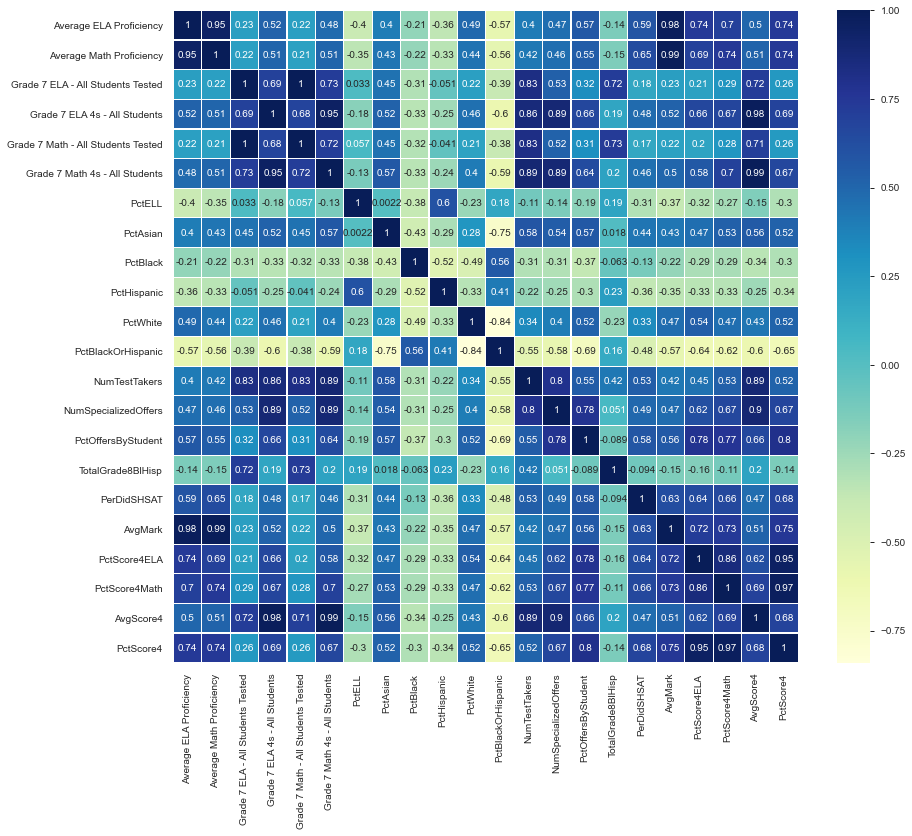

In [238]:
_ = plt.figure(figsize = (14,12))
sns.heatmap(df_main.iloc[:,15:].corr(), linewidths=.1, cmap="YlGnBu", annot=True)

**Pair Plot**

Here we can see the relationships between the number of Specialized High School offers (NumSpecializedOffers) and the race and percent of students who're scoring 4 on the ELA & Math tests.

There looks to be a strong (postive) relationship between the number of test takers and the number of of Specialized High School offers. This may be interesting to contemplate: the more students you send to the SHSAT, the more offers a school will get. 

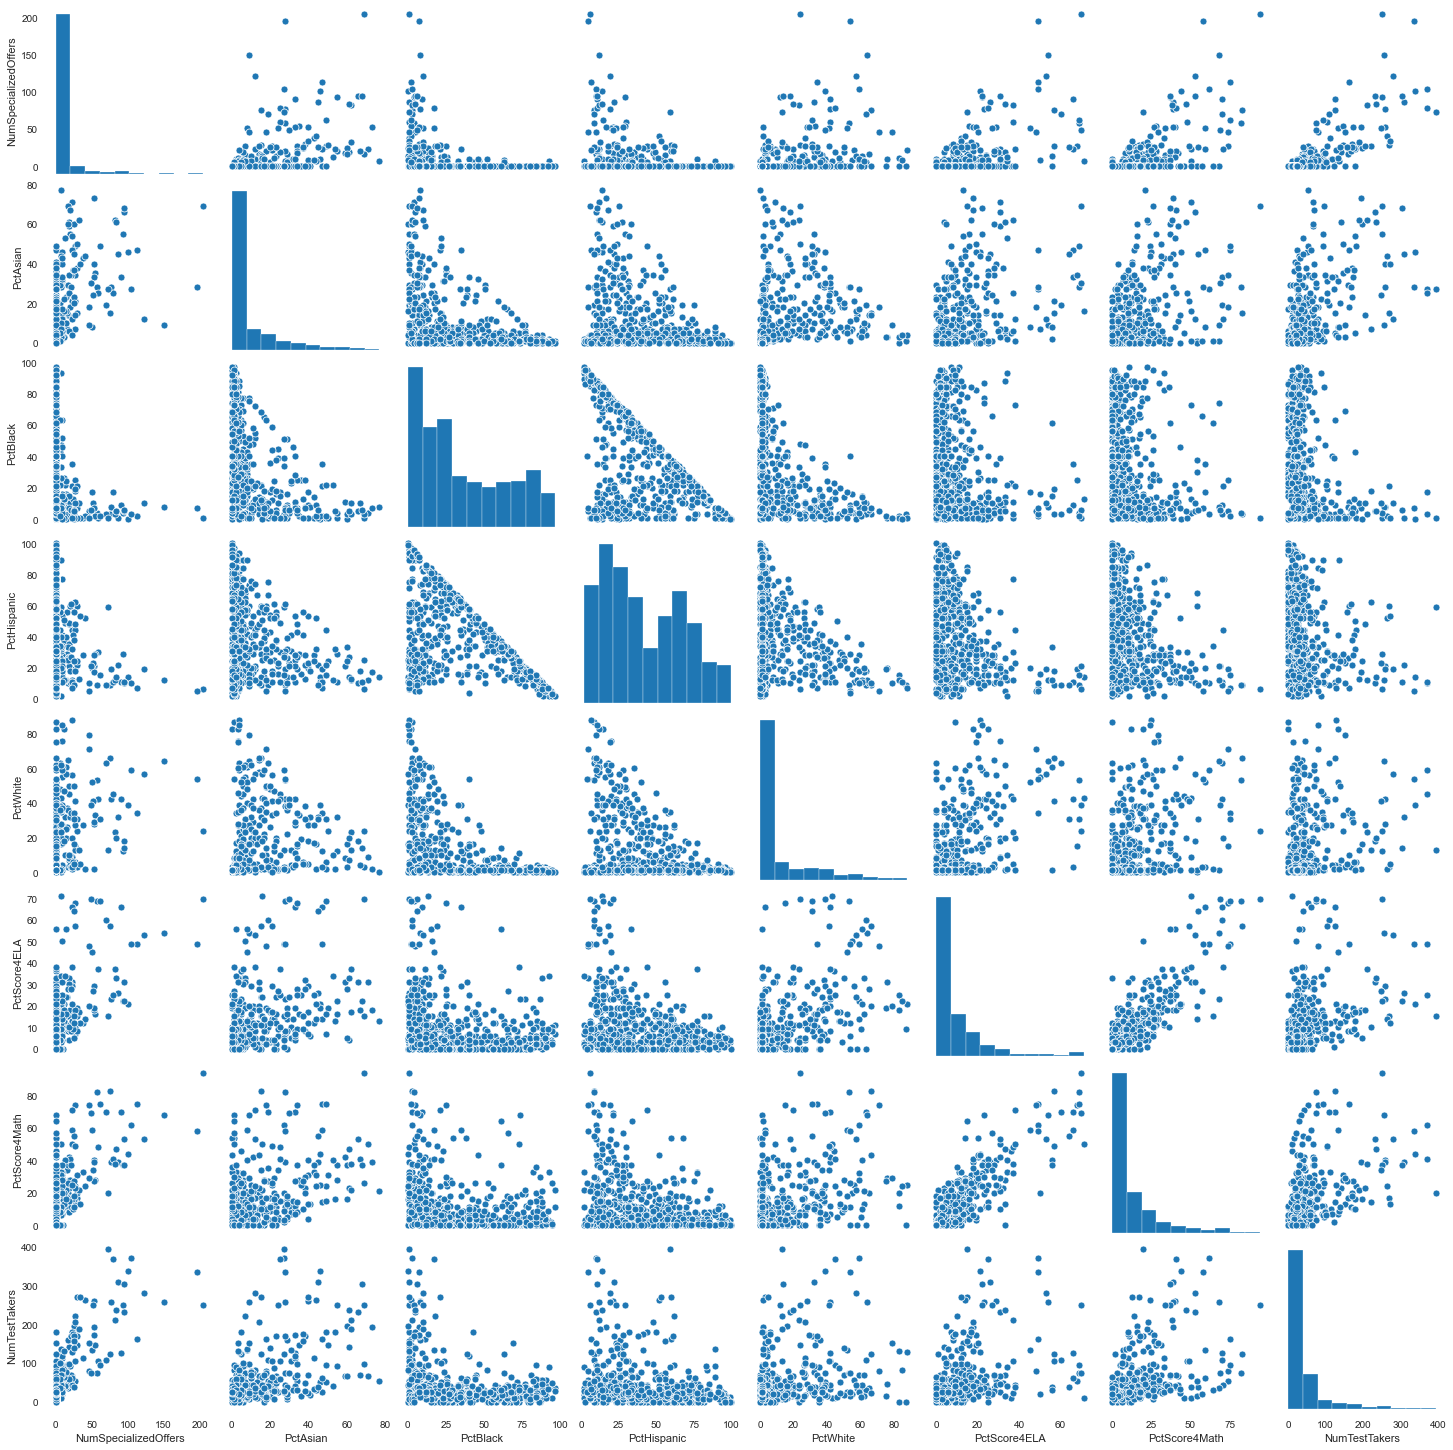

In [241]:
g = sns.pairplot(df_main, vars = ['NumSpecializedOffers', 'PctAsian', 'PctBlack', 'PctHispanic', 'PctWhite',
                                  'PctScore4ELA', 'PctScore4Math', 'NumTestTakers'])

### Pre-processing & Training Data Development ###

Here, I'll assess whether I can/ought to create dummy or indicator features for categorical variables.

I'll also perform the following steps:

- Standardize the magnitude of numeric features using a scaler
- Split your data into testing and training datasets

In [25]:
# creating dummy or indicator features for categorical variables doesn't make sense to do given my dataset
# the only categorical varaible of importance is the school name

df_analysis_dummies = pd.get_dummies(df_analysis, drop_first = 'True', dtype = 'int')
df_analysis_dummies.columns

Index(['count_of_students_in_hs_admissions', 'District', 'Latitude',
       'Longitude', 'Average ELA Proficiency', 'Average Math Proficiency',
       'Grade 7 ELA - All Students Tested', 'Grade 7 ELA 4s - All Students',
       'Grade 7 Math - All Students Tested', 'Grade 7 Math 4s - All Students',
       ...
       'feeder_school_name_WEST PREP ACADEMY',
       'feeder_school_name_WILLIAMSBURG COLLEGIATE CHARTER SCHOOL',
       'feeder_school_name_WORLD JOURNALISM PREPARATORY: A COLLEGE BOARD SCHOOL',
       'feeder_school_name_YORK EARLY COLLEGE ACADEMY',
       'feeder_school_name_YORKVILLE EAST MIDDLE SCHOOL',
       'feeder_school_name_YOUNG WOMEN'S LEADERSHIP SCHOOL',
       'feeder_school_name_YOUNG WOMEN'S LEADERSHIP SCHOOL OF BROOKLYN',
       'feeder_school_name_YOUNG WOMEN'S LEADERSHIP SCHOOL OF THE BRONX',
       'feeder_school_name_YOUNG WOMEN'S LEADERSHIP SCHOOL, ASTORIA',
       'feeder_school_name_YOUNG WOMEN'S LEADERSHIP SCHOOL, QUEENS'],
      dtype='object', length=6

In [47]:
# paring down the number of columns to only non-duplicative/necessary
# keeping the school's name as only categorical variable

df_analysis = df_main.drop(columns = ['feeder_school_dbn','count_of_testers','count_of_offers','Location Code',
                                     'Percent ELL', 'Percent Asian', 'Percent Black', 'Percent Hispanic', 
                                      'Percent Black / Hispanic', 'Percent White'])

In [48]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 590
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   feeder_school_name                  591 non-null    object 
 1   count_of_students_in_hs_admissions  591 non-null    float64
 2   District                            591 non-null    int64  
 3   Latitude                            591 non-null    float64
 4   Longitude                           591 non-null    float64
 5   Average ELA Proficiency             591 non-null    float64
 6   Average Math Proficiency            591 non-null    float64
 7   Grade 7 ELA - All Students Tested   591 non-null    int64  
 8   Grade 7 ELA 4s - All Students       591 non-null    int64  
 9   Grade 7 Math - All Students Tested  591 non-null    int64  
 10  Grade 7 Math 4s - All Students      591 non-null    int64  
 11  PctELL                              591 non-n

In [50]:
# splitting data into X & y 
df_analysis_X = df_analysis.drop(columns = ['NumSpecializedOffers'])
df_analysis_y = df_analysis.NumSpecializedOffers

In [58]:
#splitting data into training & testing 

X_train, X_test, y_train, y_test = train_test_split(df_analysis_X.iloc[:,1:], df_analysis_y, test_size = 0.25, 
                                                    random_state = 0)

In [59]:
# Standardizing the magnitude of numeric features in training & test dataset

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train) 
scaled_X_test = scaler.fit_transform(X_test)